In [158]:
import numpy as np
from math import sqrt

import datetime
import csv
import matplotlib.pyplot as plt

from pyspark.mllib.clustering import KMeans, KMeansModel

datetime.date(2010, 5, 24)

In [159]:
with open('project/detroit.csv') as f:
    csv_file = csv.reader(f)
    next(csv_file)
    crime_list = []
    for row in csv_file:
        crime_list.append(row)

In [224]:
data = []
for row in crime_list:
    crime_date = datetime.datetime.strptime(row[2], '%m/%d/%Y').date()
    crime_pos  = np.array([float(row[-2]), float(row[-1])])
    crime_type = [x.strip() for x in row[3].split(' - ')]
    data.append([crime_date, crime_pos, crime_type])

In [226]:
data_rdd = sc.parallelize(data)
histogram_year_rdd = data_rdd.map(lambda x: (x[0].month, 1)).reduceByKey(lambda x, y: x + y).sortByKey()
year_count = histogram_year_rdd.take(12)
histogram_category_rdd = data_rdd.flatMap(lambda x: [(category, 1) for category in x[2]]).reduceByKey(lambda x, y: x + y).sortByKey()
category_count = histogram_category_rdd.collect()
category_count

[('', 8),
 ('(OTHER)', 239),
 ('70 ZONE', 1),
 ('ABANDONED VEHICLE', 1640),
 ('ABDUCT -NO RANSOM OR ASSAULT', 19),
 ('ABILITY IMPAIRED BY ALCOHOL, VOLUNTARY', 2),
 ('ACCIDENT', 858),
 ('ACCIDENT, FAILED TO REPORT', 36),
 ('ACCIDENT, FIRE', 100),
 ('ACCIDENT, NON-TRAFFIC', 571),
 ('ACCIDENTS, ALL OTHER NON-CRIMINAL', 301),
 ('AGG/FEL ASSAULT', 8261),
 ('AGGRAVATED STALKING (FELONY)', 27),
 ('AIRCRAFT SAFETY VIOLATIONS', 2),
 ('ALL OTHER', 228),
 ('ALL OTHERS', 3),
 ('ALTERING IDENTIFICATION', 3),
 ('AMPHETAMINE -POSSESS', 4),
 ('ANIMALS -CRUELTY TO', 29),
 ('ANIMALS AT LARGE', 27),
 ('ARSON', 329),
 ('ARSON (OTHER)', 124),
 ('ARSON -BUSINESS', 33),
 ('ARSON -PUBLIC BUILDING', 10),
 ('ARSON -RESIDENCE', 421),
 ('ASSAULT (OTHER)', 251),
 ('ASSAULT AND BATTERY/SIMPLE ASSAULT', 12440),
 ('ASSAULT LESS THAN MURDER', 2),
 ('ASSAULT W/INTENT TO MURDER', 37),
 ('ASSAULT, INTENT TO COMMIT FELONY', 36),
 ('ASSAULT, INTENT TO MAIM', 14),
 ('ATTEMPTED ROBBERY -ARMED', 184),
 ('ATTEMPTED ROBBERY -UN

<Container object of 12 artists>

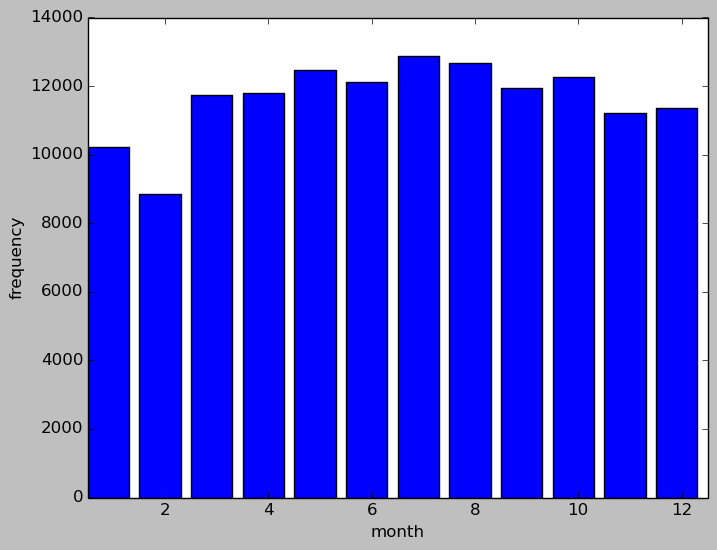

In [216]:
month = [x[0] - 0.5 for x in year_count]
freq = [x[1] for x in year_count]
plt.xlabel('month')
plt.ylabel('frequency')
plt.xlim([0.5,12.5])
plt.bar(month, freq)

<Container object of 451 artists>

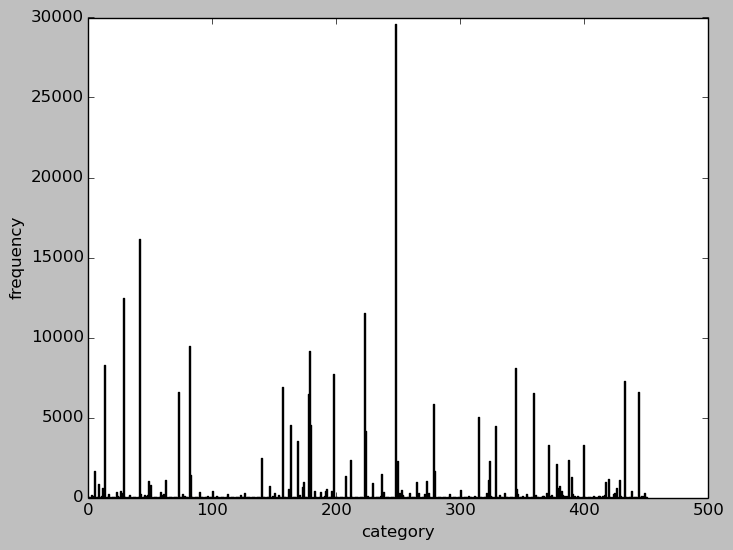

In [222]:
category = [x for x in category_count]
freq = [x[1] for x in category_count]
plt.xlabel('category')
plt.ylabel('frequency')
plt.bar(range(len(category)),freq)

In [209]:
pos_rdd = data_rdd.map(lambda line: line[1])
clusters = KMeans.train(pos_rdd, 2, maxIterations=10, initializationMode="random")

In [229]:
def category_filter(entry, category_types):
    for category in category_types:
        for entry_category in entry:
            if category in entry_category:
                return True
    return False

In [237]:
def cluster(date_range, category_types, num_clusters):
    filtered_rdd = data_rdd.filter(lambda x: x[0].month in date_range and category_filter(x[2], category_types))
    clusters = KMeans.train(pos_rdd, num_clusters, maxIterations=100, initializationMode="random")
    label_rdd = filtered_rdd.map(lambda x: [x[1], clusters.centers[clusters.predict(x[1])]]).collect()
    return label_rdd, clusters.centers

In [152]:
def sse(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

In [141]:
WSSSE = pos_rdd.map(lambda point: sse(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 8081.66942017


In [238]:
label, centers = cluster([1, 2], ['MURDER'], 10)

In [239]:
label

[[array([ 42.4313, -83.1895]), array([ 42.41530598, -83.19131462])],
 [array([ 42.3005, -83.1012]), array([ 42.31622789, -83.12432599])],
 [array([ 42.3927, -82.983 ]), array([ 42.4170758 , -82.96375891])],
 [array([ 42.409 , -83.1362]), array([ 42.42517955, -83.13321421])],
 [array([ 42.4089, -83.136 ]), array([ 42.42517955, -83.13321421])],
 [array([ 42.436 , -83.1005]), array([ 42.42517955, -83.13321421])],
 [array([ 42.4346, -83.1559]), array([ 42.42517955, -83.13321421])],
 [array([ 42.3557, -83.0148]), array([ 42.36742357, -83.00769418])],
 [array([ 42.4308, -82.9875]), array([ 42.4170758 , -82.96375891])],
 [array([ 42.3881, -83.2281]), array([ 42.35871797, -83.21897424])],
 [array([ 42.4192, -83.1394]), array([ 42.42517955, -83.13321421])],
 [array([ 42.3841, -83.2517]), array([ 42.41760455, -83.25124597])],
 [array([ 42.3755, -83.074 ]), array([ 42.34975273, -83.06424793])],
 [array([ 42.4051, -82.9677]), array([ 42.4170758 , -82.96375891])],
 [array([ 42.3584, -83.1318]), arr